In [60]:
!pip install swig
!pip install gymnasium[box2d]
!pip install git+https://github.com/arnavg115/agrad.git

  Cloning https://github.com/arnavg115/agrad.git to /tmp/pip-req-build-964atbwg
  Running command git clone --filter=blob:none --quiet https://github.com/arnavg115/agrad.git /tmp/pip-req-build-964atbwg
  Resolved https://github.com/arnavg115/agrad.git to commit 8504d2106888e211ec8b71ad71043c84f0bfb504
  Preparing metadata (setup.py) ... done


In [1]:
import gymnasium as gym
import random

In [40]:
import agrad
from agrad import Module, F, Tensor
import agrad.nn as nn
from agrad.nn import MSE
import agrad.nn.optimizer as optim
import numpy as np
from collections import deque

In [3]:
class mlp(Module):
  def __init__(self, obs, action):
    self.l1 = nn.Linear(obs, 64)
    self.l2 = nn.Linear(64, 64)
    self.l3 = nn.Linear(64,action)

  def forward(self, x):
    y = F.relu(self.l1(x))
    y = F.relu(self.l2(y))
    return self.l3(y)

In [30]:
env = gym.make("LunarLander-v2")

In [45]:
eps = 0.99
decay = 0.995
gamma = 0.99
min_eps = 0.1
lr = 5e-4
batch_size = 64
tau = 1e-3
qn = mlp(env.observation_space.shape[0],env.action_space.n)
moving_rew = deque(maxlen=5)

def get_action(eps, obs):
  n = random.random()
  if n < eps:
    return random.randint(0,env.action_space.n-1)
  out = qn(obs).data
  return int(np.argmax(out))

criterion = MSE()
optimizer = optim.adam(lr = lr)

states = []
next_states = []
actions = []
rewards = []
dones = []
lengs = []
lossesss = []


tot = 0
for ep in range(10000):
  done = False
  obs, _ = env.reset()
  lens = 0
  final_rew = 0
  learned = 0
  avg_loss = 0
  while not done:
    action = get_action(eps, Tensor(obs))
    next_obs, reward, terminated, truncated, info = env.step(action)
    final_rew+=reward
    ds = terminated or truncated

    states.append(obs)
    next_states.append(next_obs)
    rewards.append(reward)
    actions.append(action)
    dones.append(int(ds))

    if len(states) > 1e5:
      states = states[1:]
      next_states = next_states[1:]
      rewards = rewards[1:]
      actions = actions[1:]
      dones = dones[1:]

    if batch_size < len(states) and tot % 4 == 0:
      inds = random.sample(range(len(states)),batch_size)
      b_states = Tensor(np.array([states[i] for i in inds]))
      b_n = Tensor(np.array([next_states[i] for i in inds]))
      b_actions = Tensor(np.array([actions[i] for i in inds])).reshape((-1,1))
      b_rewards = Tensor(np.array([rewards[i] for i in inds])).reshape((-1,1))
      b_dones = Tensor(np.array([dones[i] for i in inds])).reshape((-1,1))
      qpred = qn(b_states)
      qp = agrad.gather(qpred, b_actions.data, 1)
      # qpred = qpred.gather(1, b_actions)

      max_n = qn(b_n).data.max(axis=1)
      max_n = max_n.reshape(-1,1)

      tgt = b_rewards + (-b_dones + 1) * max_n * gamma

      qn.zero_grad()

      loss = criterion(qp, tgt)
      criterion.backward()
      optimizer.step(qn)
      learned+=1
      avg_loss+=loss.item()
    lens+=1
    tot+=1
    obs = next_obs
    done = terminated or truncated
  if ep > 5:
    eps = max(min_eps, eps * decay)
  lengs.append(lens)
  moving_rew.append(final_rew)
  if learned > 0:
    lossesss.append(avg_loss/learned)
    print(f"Ep {ep}, avg_loss: {avg_loss/learned}, len: {lens}, eps: {eps}, reward:{final_rew}")
  else:
    print(f"Ep {ep}, len: {lens}, eps: {eps}, reward: {final_rew}")
  if sum(moving_rew)/len(moving_rew) > 200:
    print("Env solved")
    break


Ep 0, avg_loss: 541.6130897267232, len: 90, eps: 0.99, reward:-345.25573954788683
Ep 1, avg_loss: 5080.211942877813, len: 105, eps: 0.99, reward:-134.9696682394527
Ep 2, avg_loss: 8691.011546047672, len: 70, eps: 0.99, reward:-171.82885246289422
Ep 3, avg_loss: 8049.47642714932, len: 73, eps: 0.99, reward:-175.3760395896798
Ep 4, avg_loss: 9719.528879998947, len: 79, eps: 0.99, reward:-114.99855996429218
Ep 5, avg_loss: 6540.696360918275, len: 108, eps: 0.99, reward:-102.38894466104807
Ep 6, avg_loss: 4798.391973639979, len: 125, eps: 0.98505, reward:-227.93758703483667
Ep 7, avg_loss: 6165.521601996528, len: 108, eps: 0.98012475, reward:-106.5805321747141
Ep 8, avg_loss: 5304.996116134216, len: 102, eps: 0.97522412625, reward:-250.83175010805857
Ep 9, avg_loss: 6772.365694235605, len: 122, eps: 0.97034800561875, reward:-427.73833446837455
Ep 10, avg_loss: 8948.572726665718, len: 94, eps: 0.9654962655906563, reward:-307.62485541920194
Ep 11, avg_loss: 8012.437197360311, len: 84, eps: 0

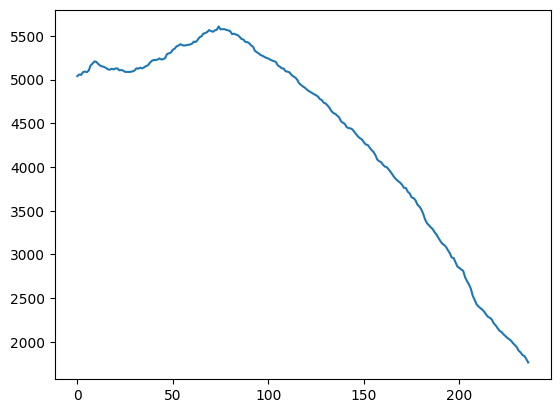

In [46]:
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

window_size = 200

smoothed_data = moving_average(lossesss, window_size)
plt.plot(smoothed_data)


In [ ]:


# https://stackoverflow.com/questions/77042526/how-to-record-and-save-video-of-gym-environment
import gymnasium as gym

###
# create a temporary variable with our env, which will use rgb_array as render mode. This mode is supported by the RecordVideo-Wrapper
tmp_env = gym.make("LunarLander-v2", render_mode="rgb_array")

# wrap the env in the record video
tmenv = gym.wrappers.RecordVideo(env=tmp_env,video_folder="/content/new",name_prefix="test-video", episode_trigger=lambda x: x % 1 == 0)

# env reset for a fresh start
obs, info = tmenv.reset()

###
# Start the recorder
tmenv.start_video_recorder()


# AI logic
for _ in range(1000):
    action = get_action(0, Tensor(obs))

    obs, reward, terminated, truncated, _ = tmenv.step(action)
    tmenv.render()
    if terminated or truncated:
        observation, info = env.reset()

####
# Don't forget to close the video recorder before the env!
tmenv.close_video_recorder()

# Close the environmentz
tmenv.close()

In [59]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "/content/new/test-video-episode-0.mp4"

# Compressed video path
compressed_path = "/content/videos/result_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)